In [1]:
import numpy as np
import torch
import os
from pathlib import Path
import matplotlib.pyplot as plt
import soundfile as sf

from diff_gfdn.config.config import DiffGFDNConfig
from diff_gfdn.colorless_fdn.model import ColorlessFDN
from diff_gfdn.utils import get_response
from diff_gfdn.solver import data_parser_var_receiver_pos
from diff_gfdn.colorless_fdn.model import ColorlessFDN

os.chdir('..')  # This changes the working directory to DiffGFDN
import sys
sys.path.append('/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/projects/orchi/DiffGFDN/src')
sys.path.append('/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/projects/orchi/DiffGFDN/src/run_model.py')
from run_model import load_and_validate_config


In [2]:
config_path = 'data/config/'
fig_path = 'figures/'
config_name = 'synth_data_broadband_two_coupled_rooms_grid_training_colorless_prototype.yml'
config_file = config_path + config_name
config_dict = load_and_validate_config(config_file,
                                       DiffGFDNConfig)
trainer_config = config_dict.trainer_config
checkpoint_dir = Path(trainer_config.train_dir + 'colorless-fdn/' + 'checkpoints/').resolve()
max_epochs = config_dict.colorless_fdn_config.max_epochs

In [3]:
num_freq_samples = int(3*config_dict.sample_rate)
mag = torch.ones(num_freq_samples)
angle = angle = torch.arange(0, 1, 1 / num_freq_samples)
data = torch.polar(mag, angle * np.pi) 

room_data = data_parser_var_receiver_pos(
    config_dict, num_freq_bins=trainer_config.num_freq_bins)

config_dict = config_dict.copy(update={"num_groups": room_data.num_rooms})

# create folder where to save the impulse responses 
output_dir = Path(trainer_config.train_dir + 'colorless-fdn/' + 'audio').resolve()  
os.makedirs(output_dir, exist_ok=True)



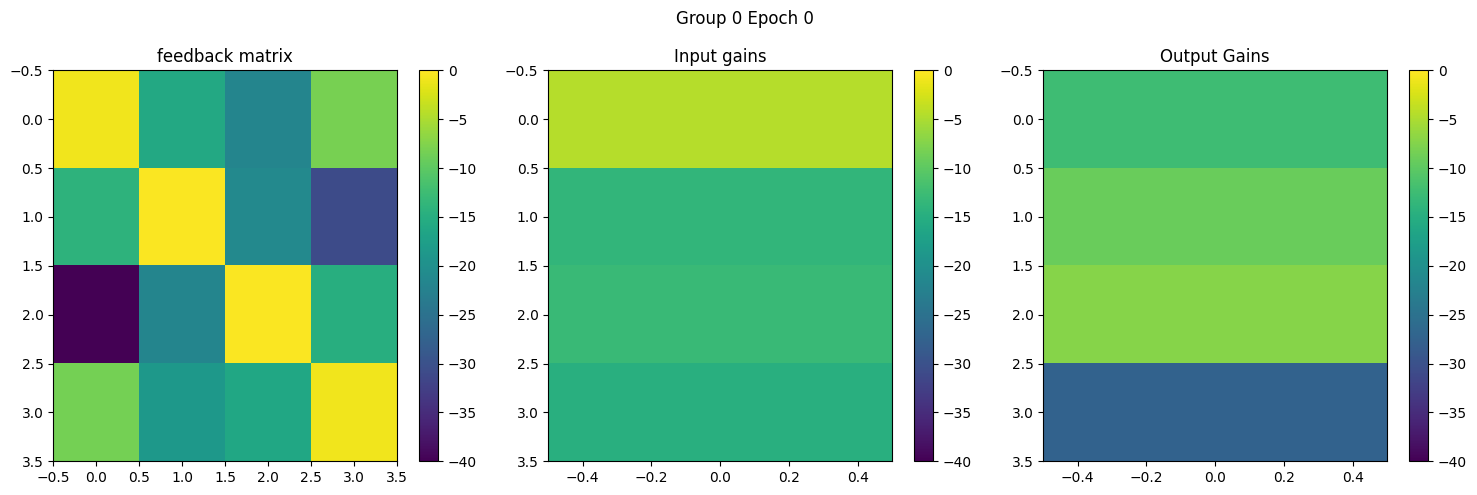

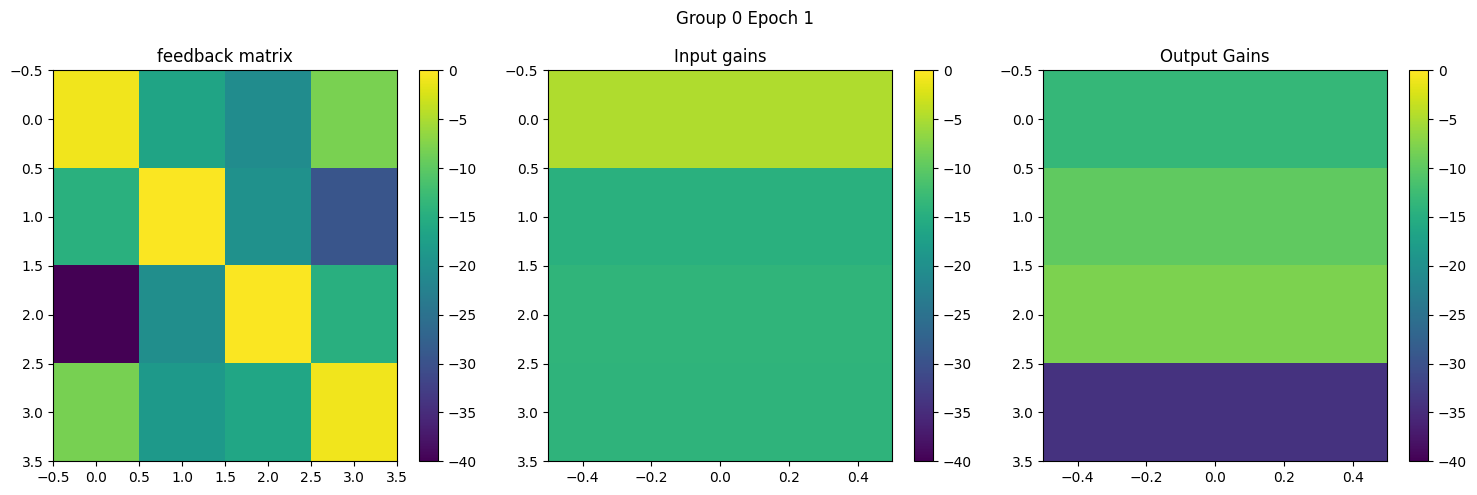

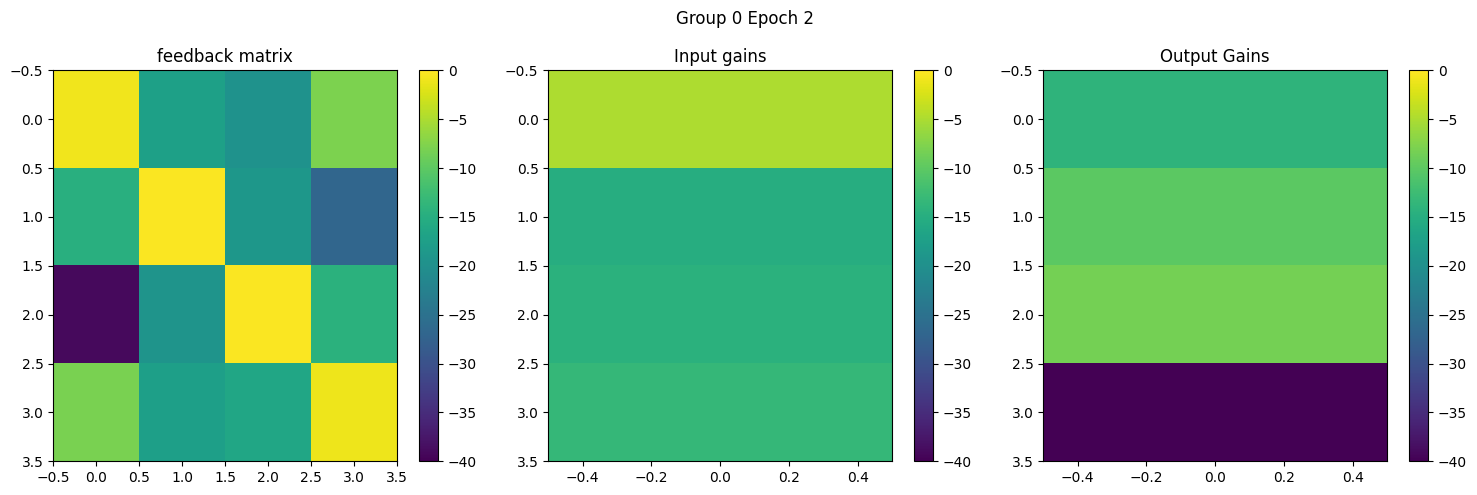

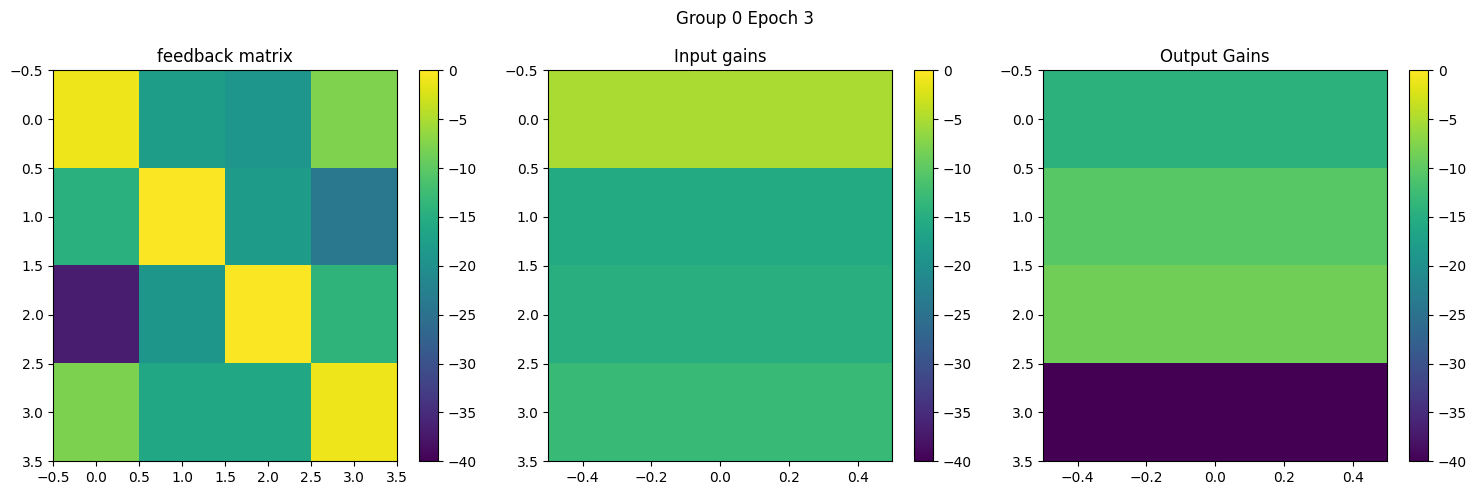

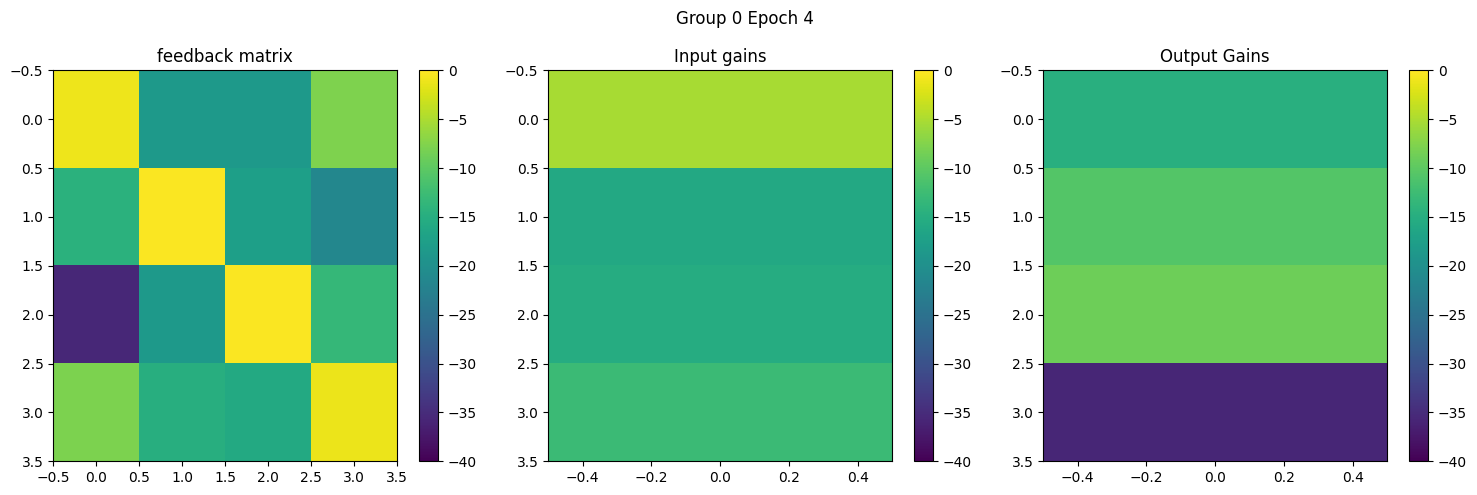

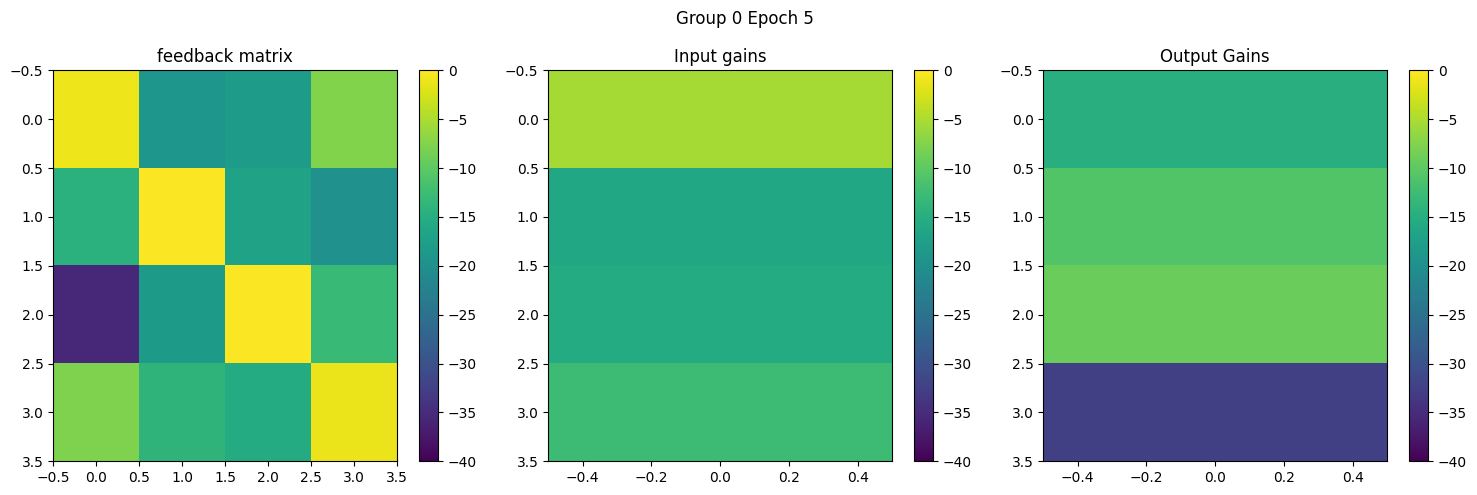

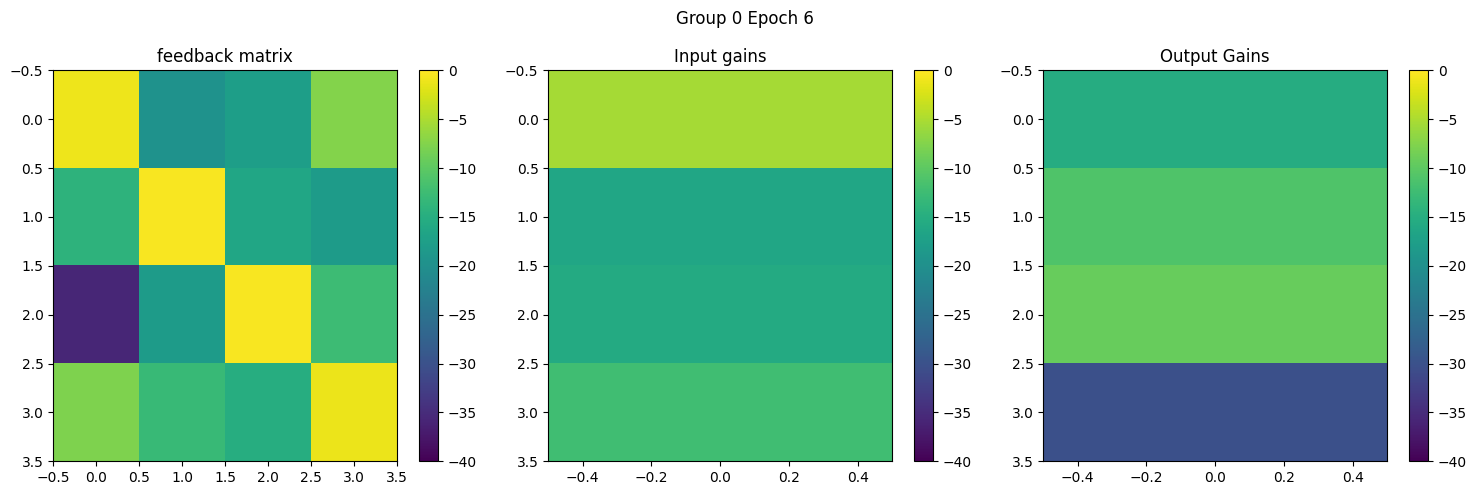

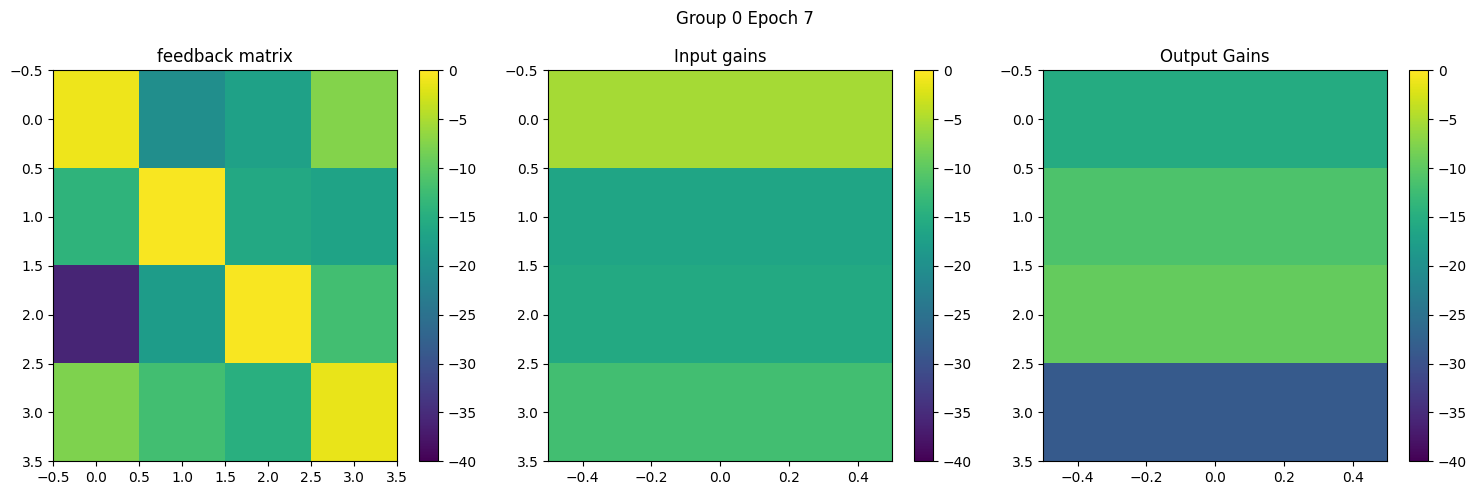

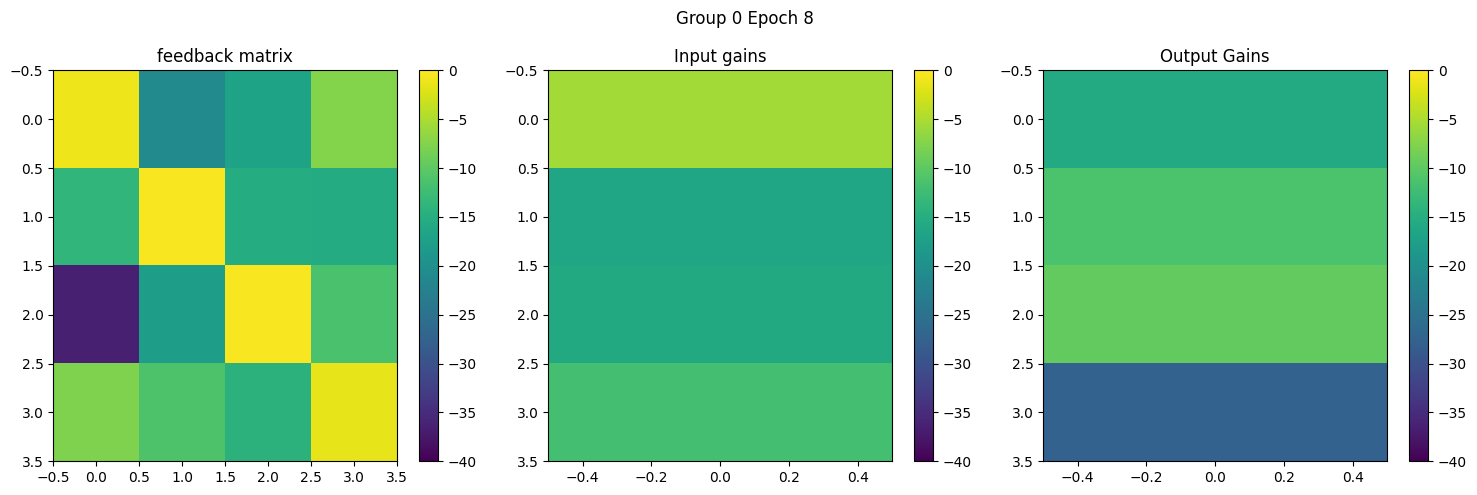

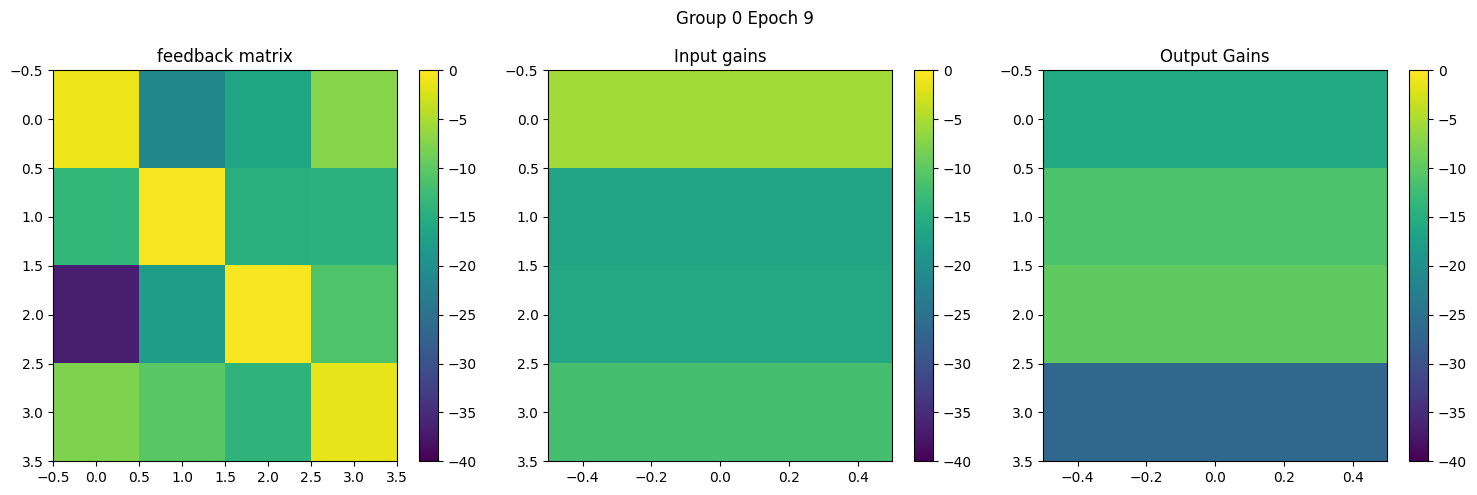

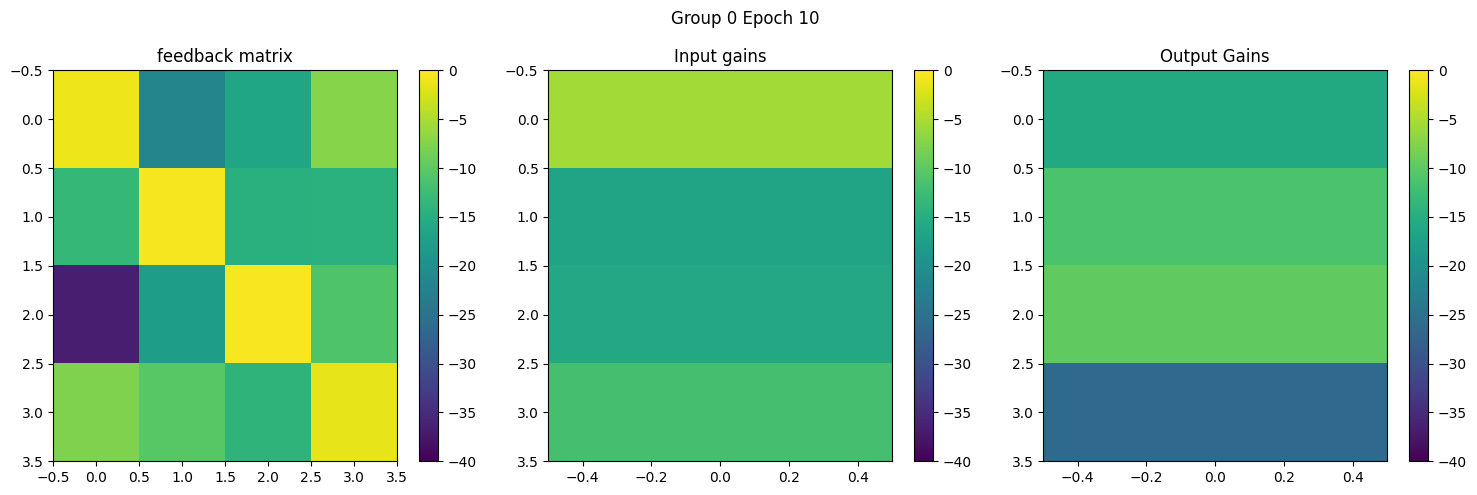

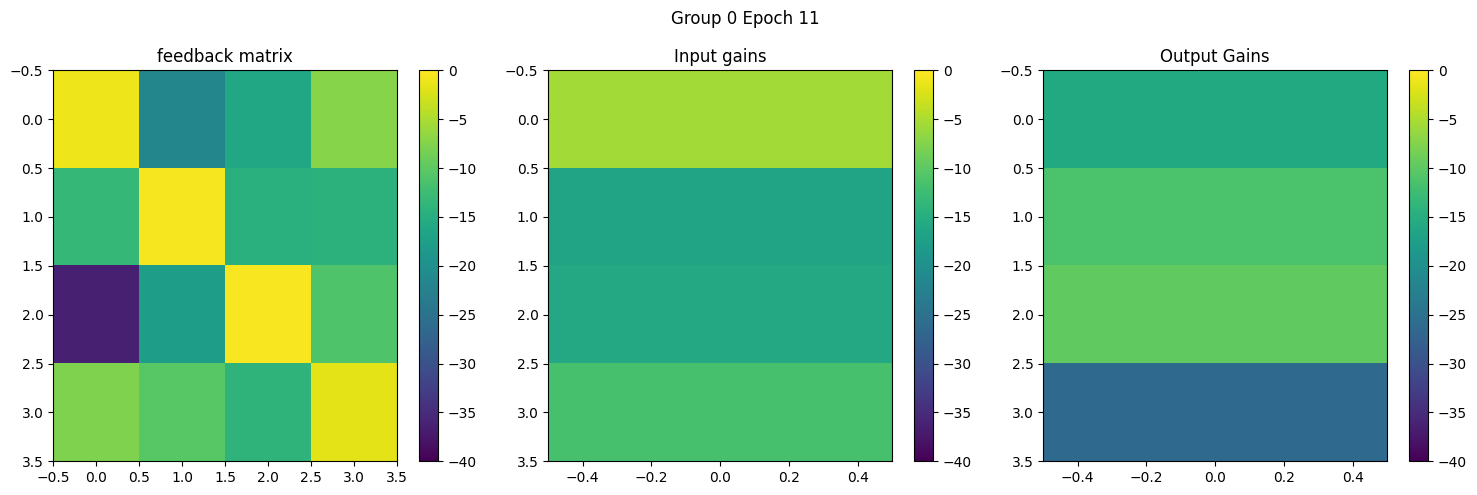

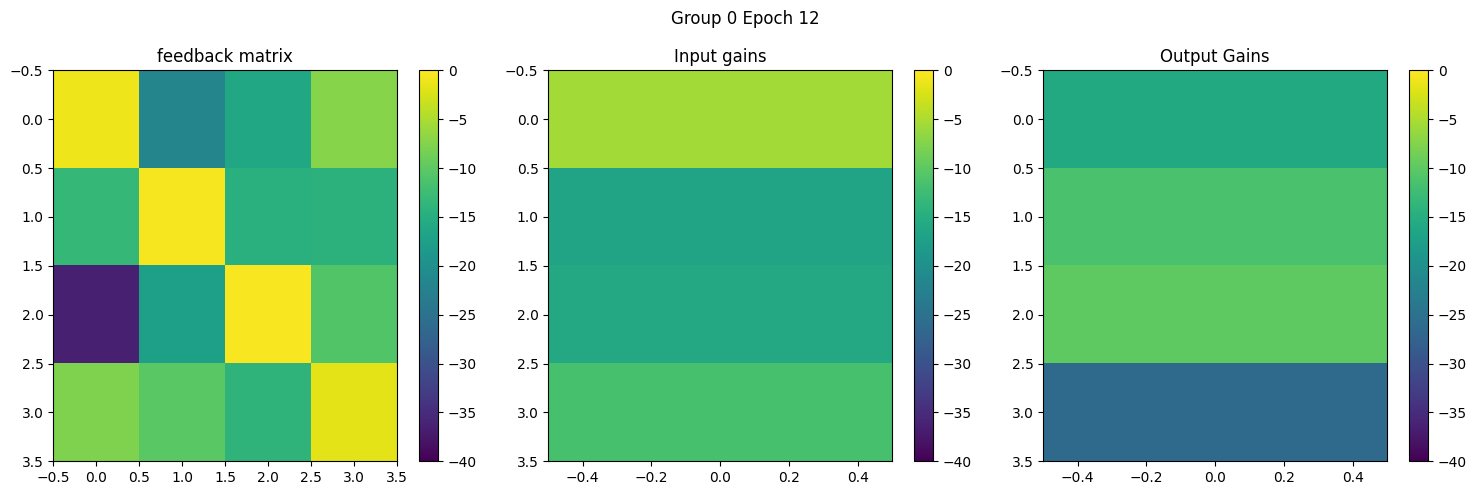

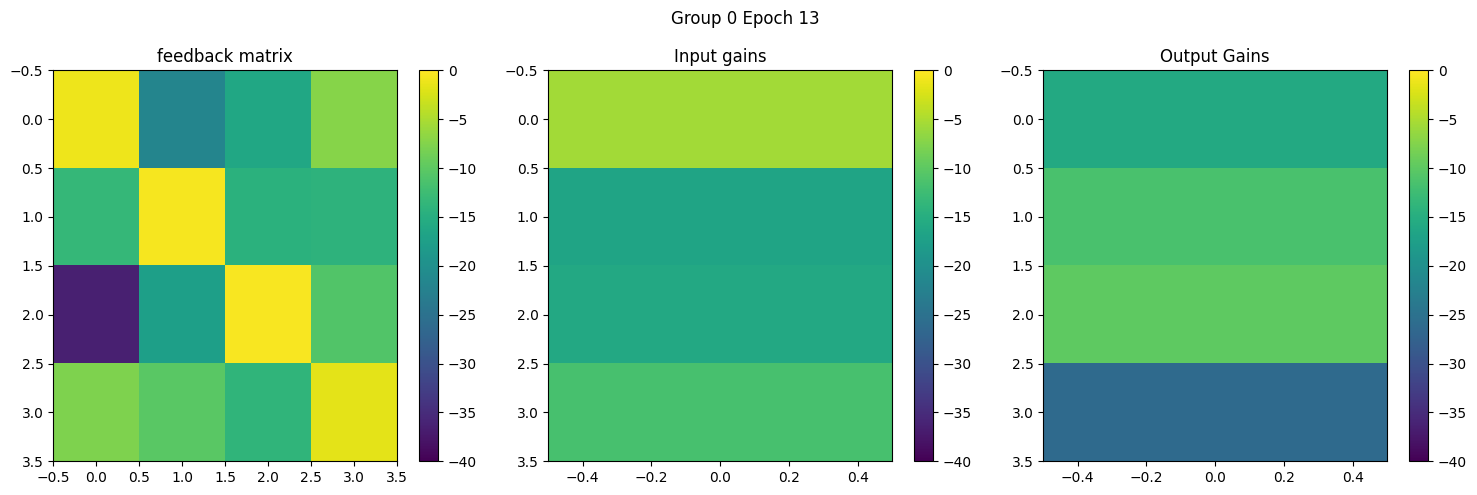

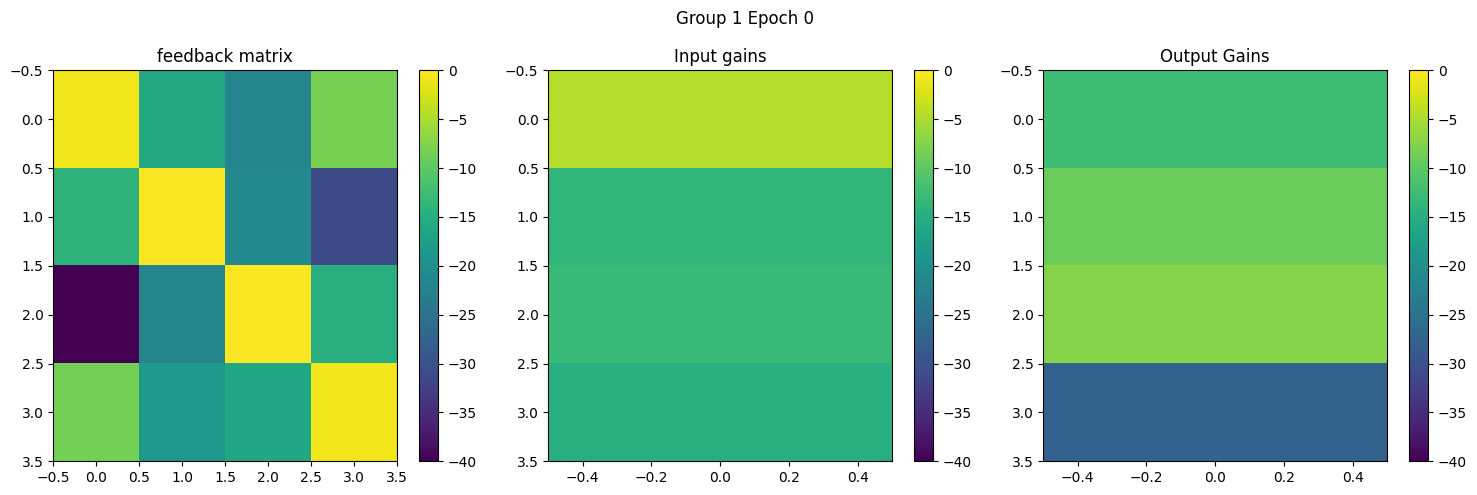

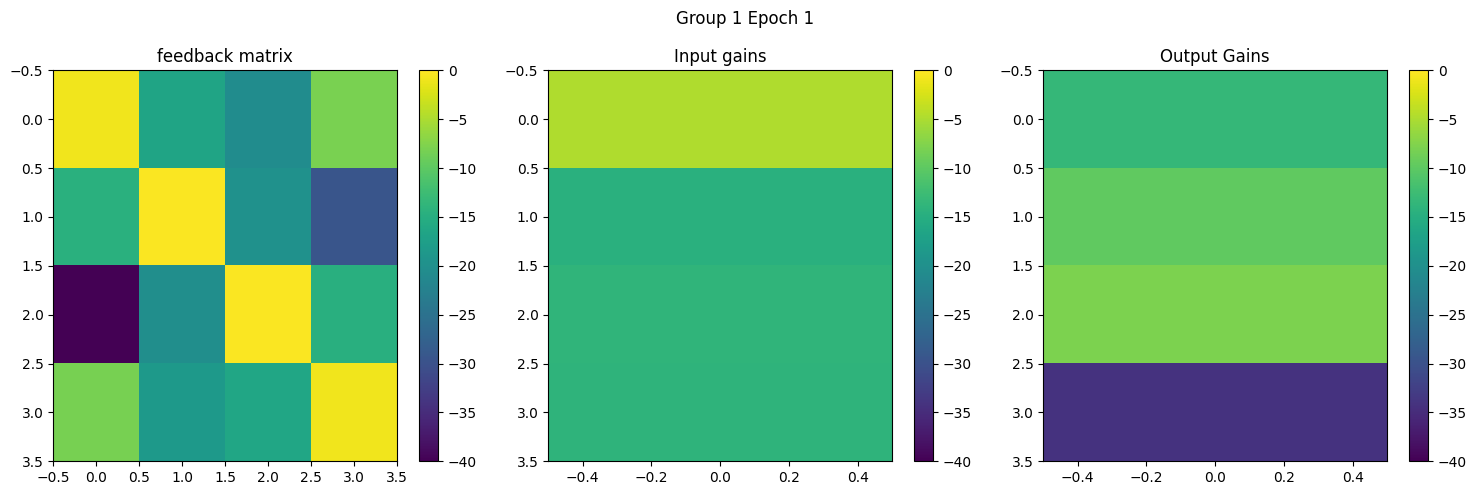

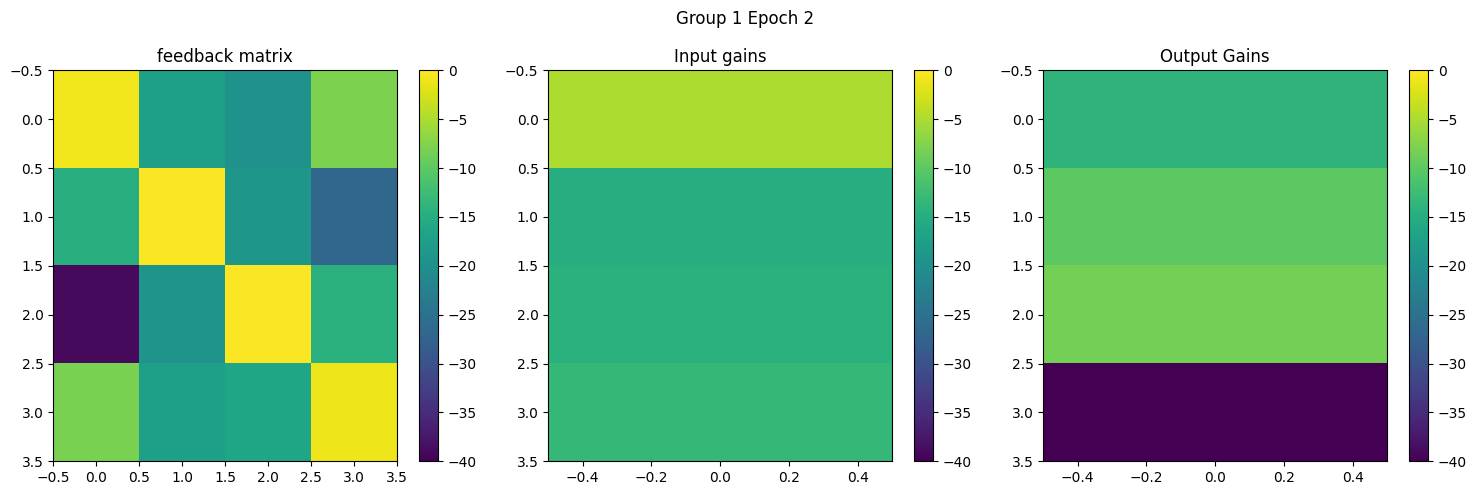

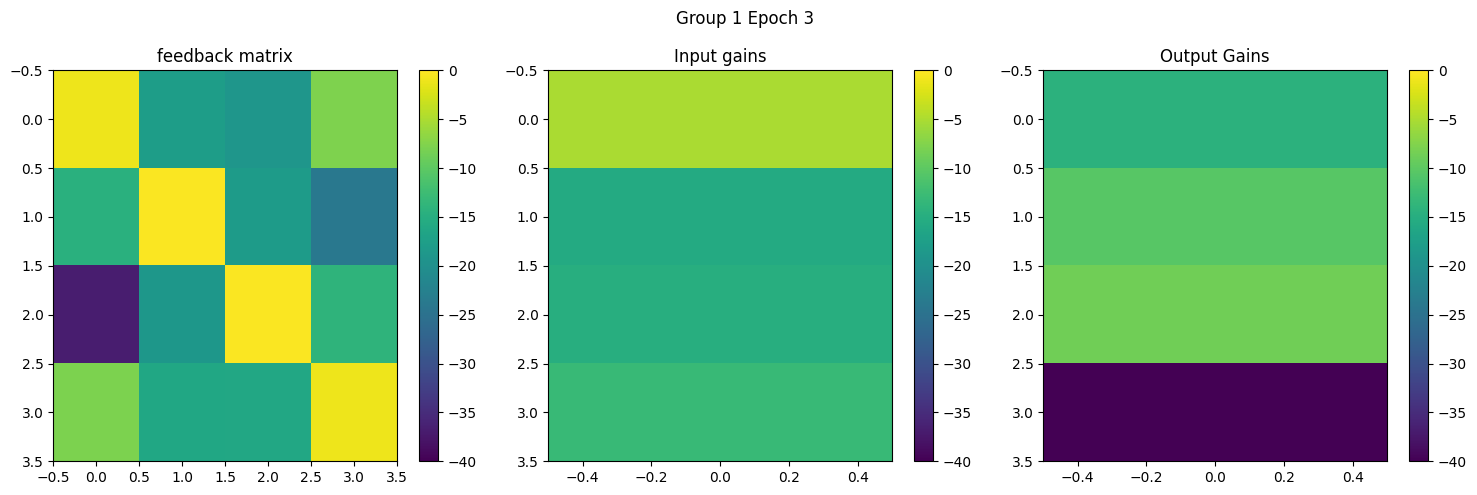

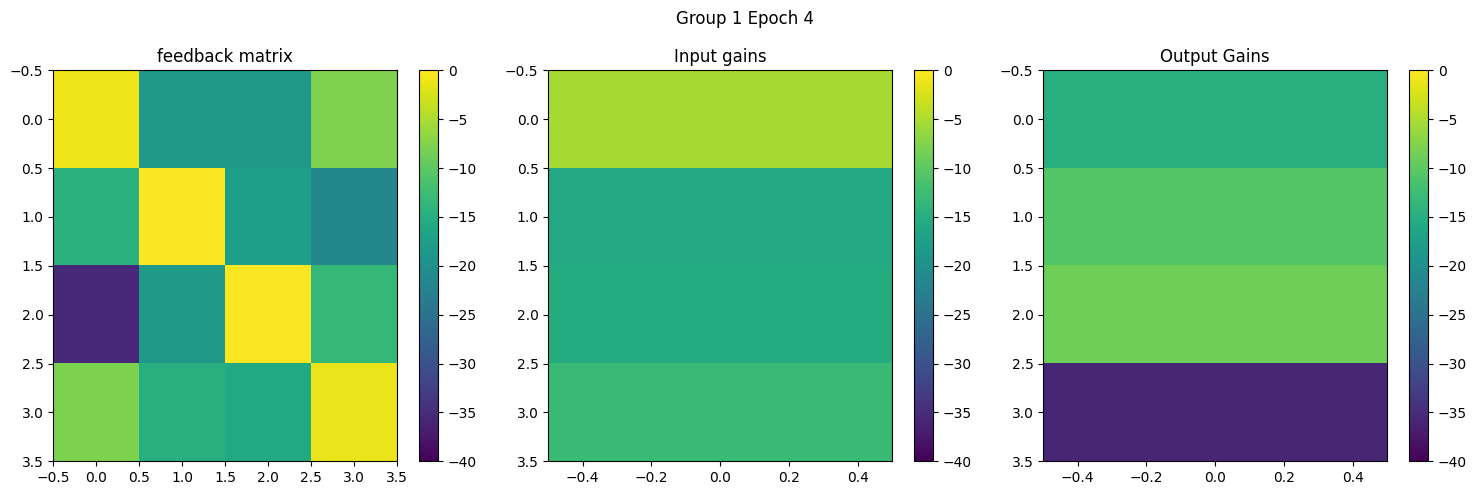

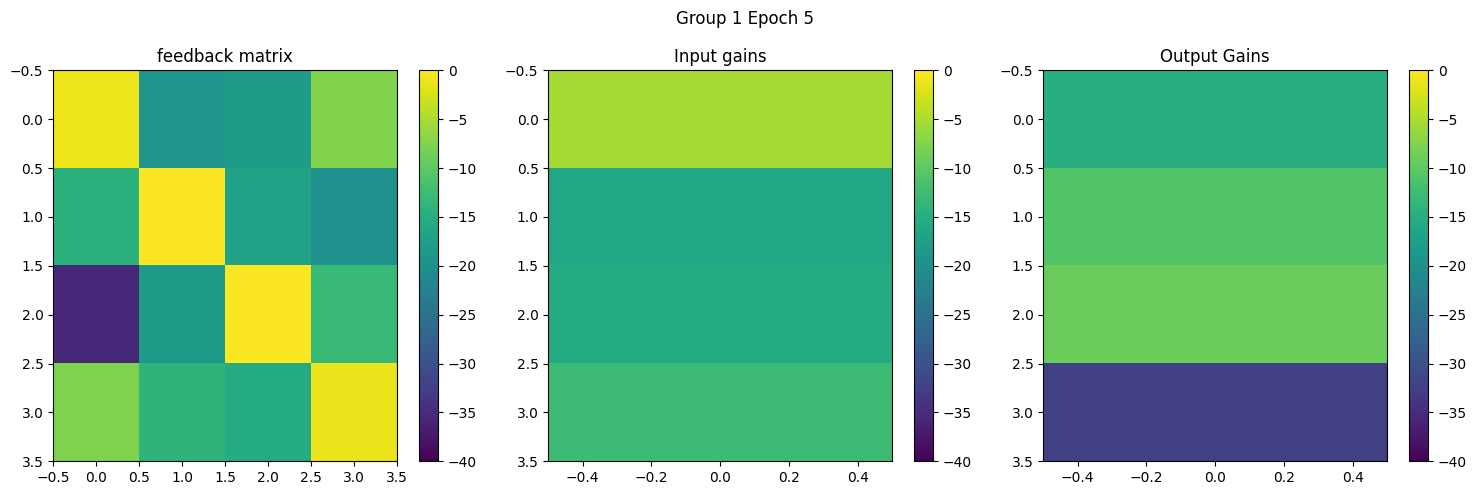

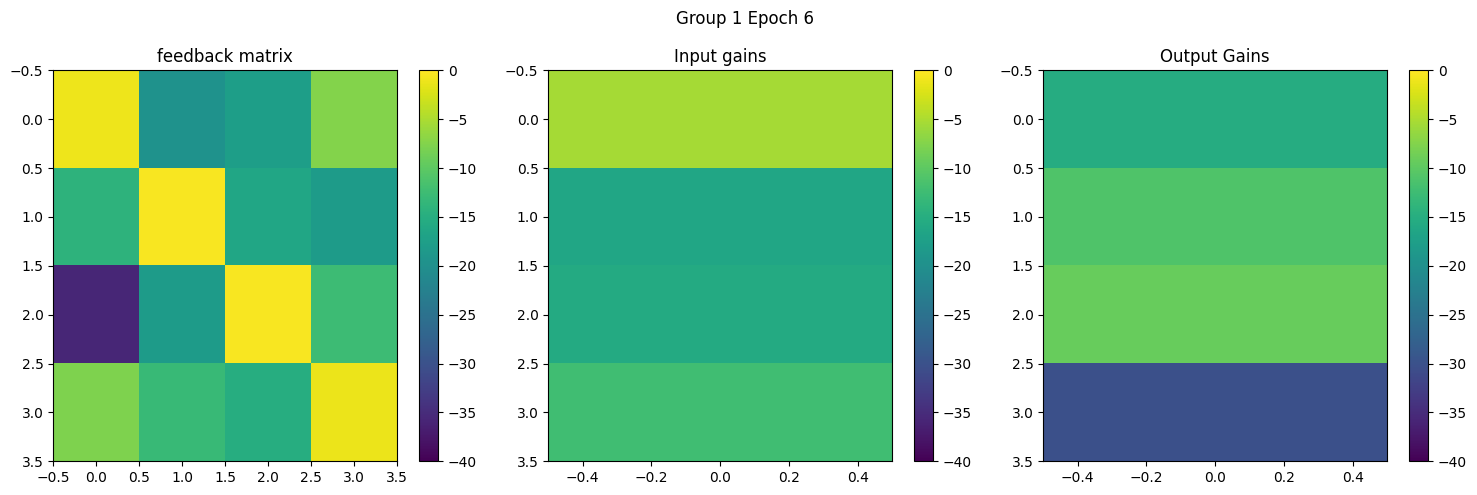

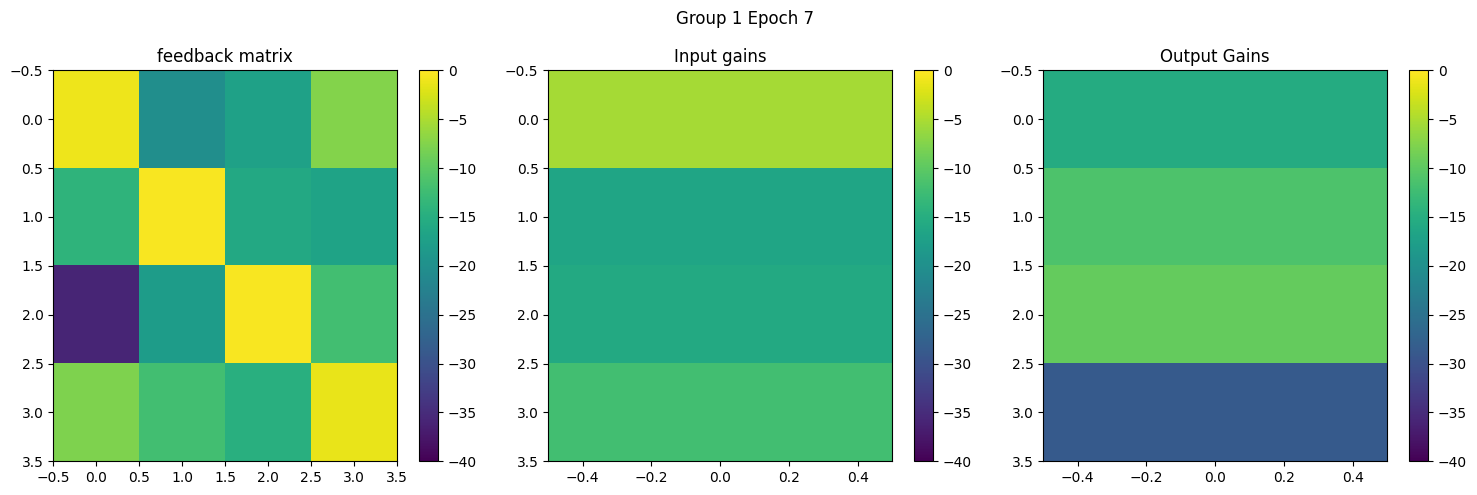

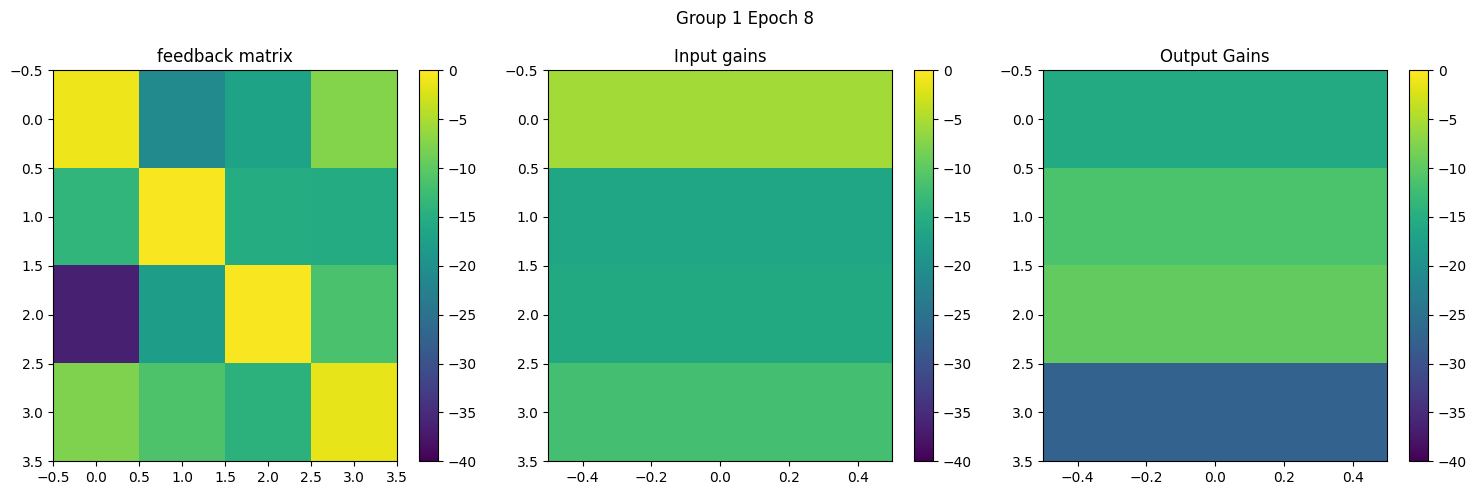

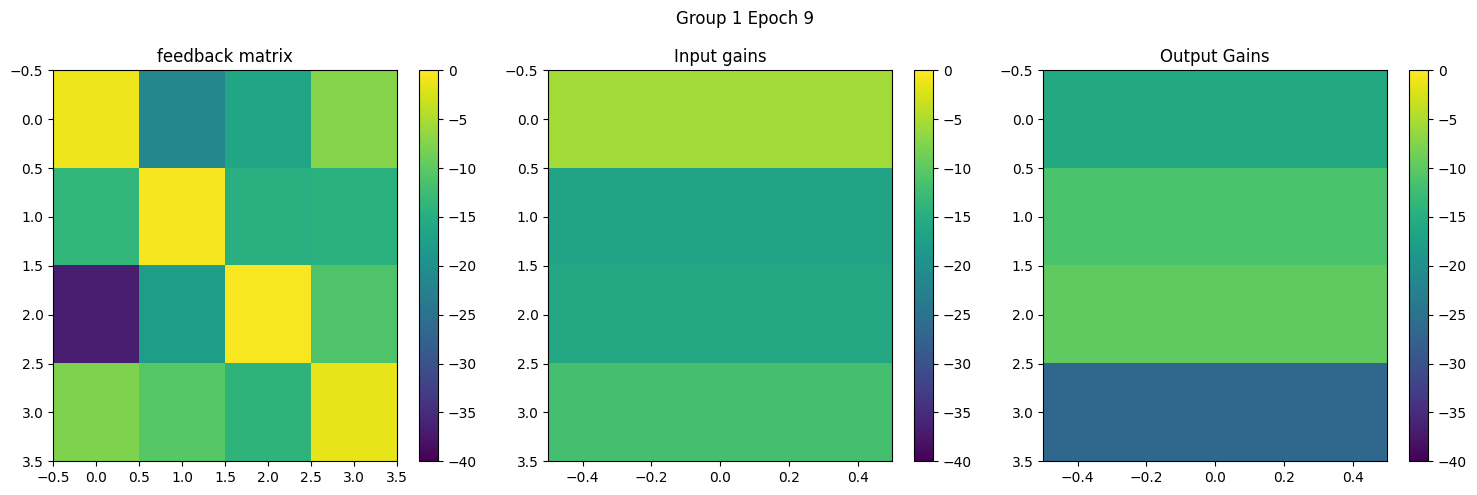

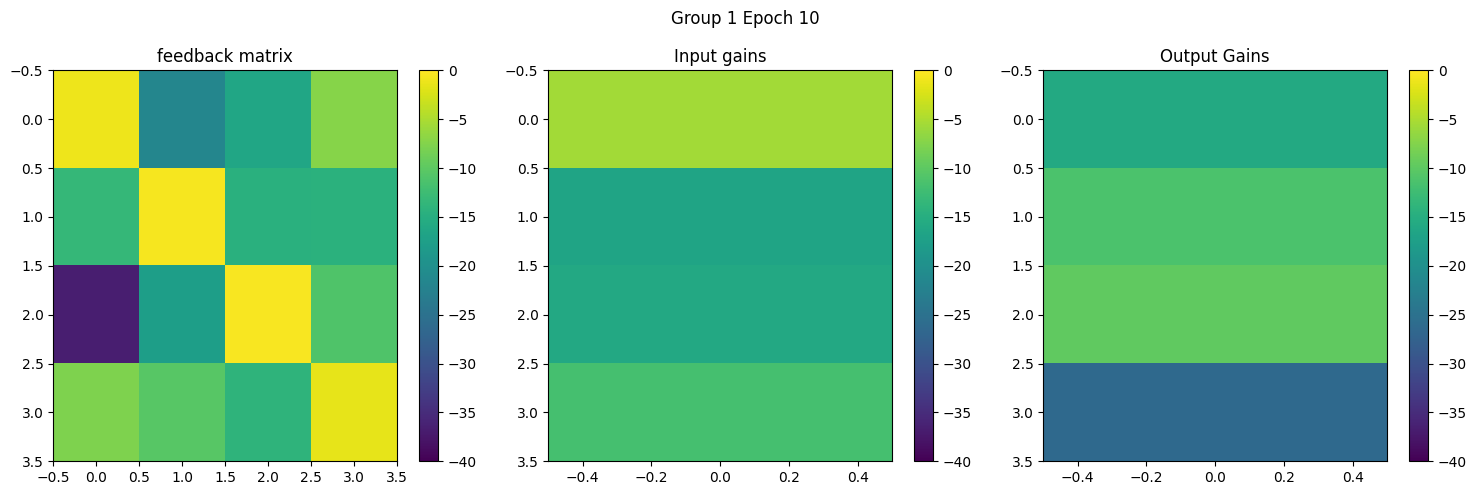

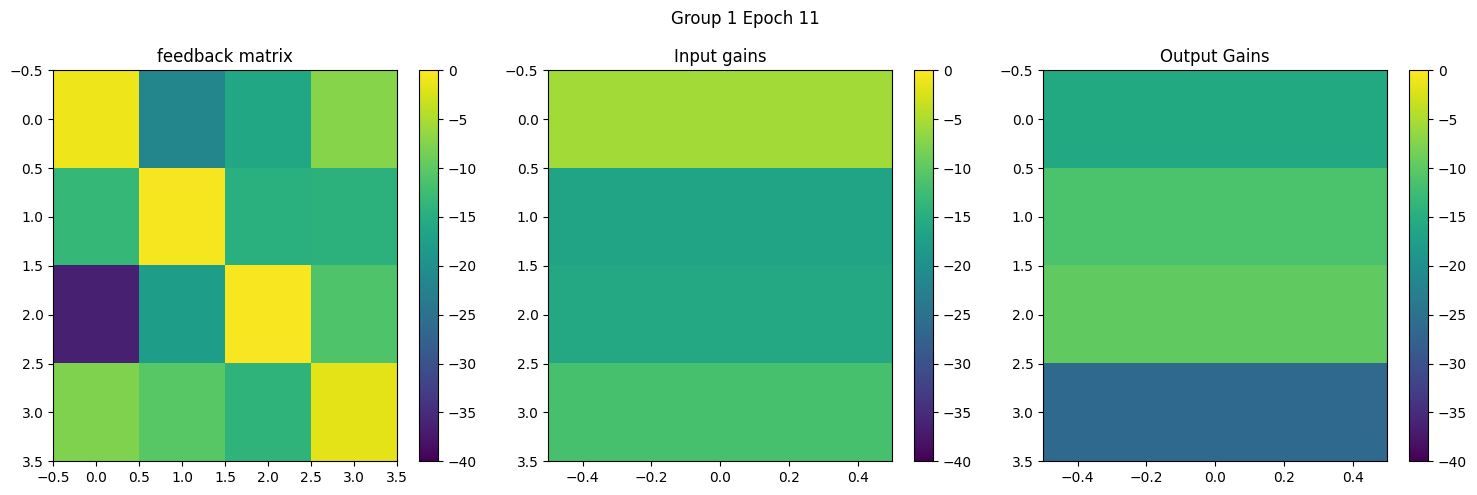

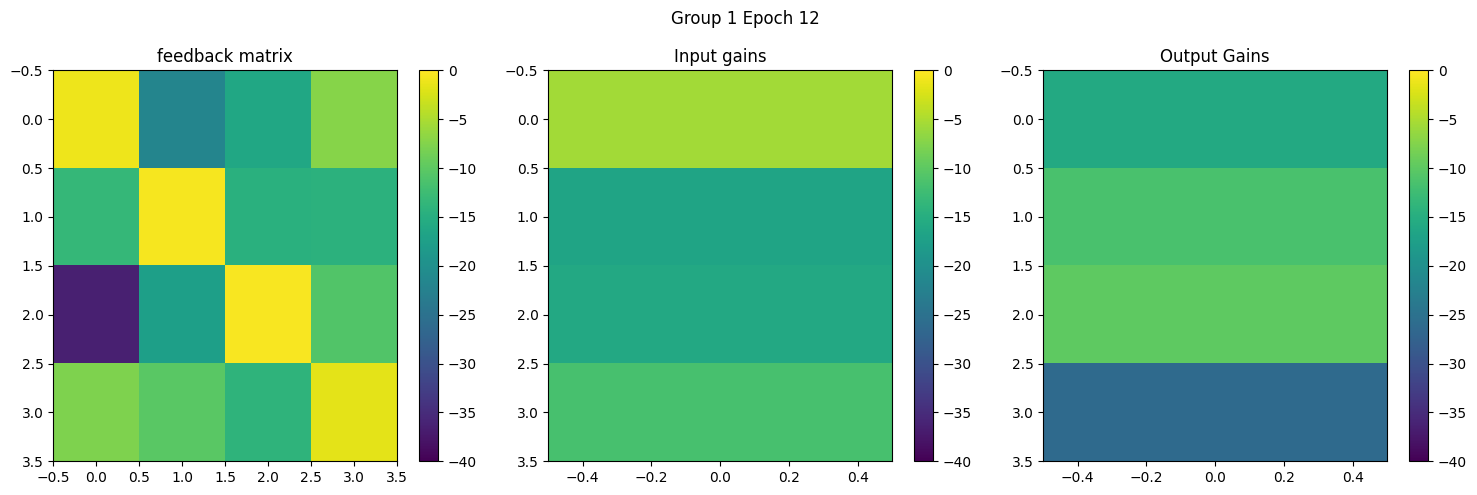

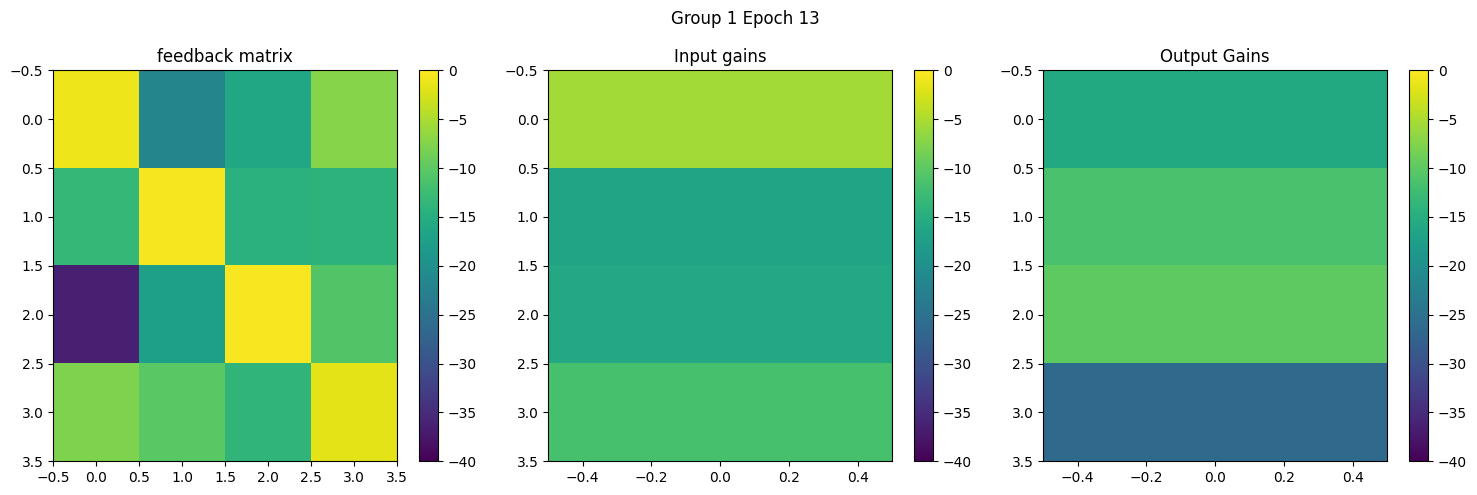

In [4]:
num_delay_lines_per_group = int(config_dict.num_delay_lines /
                                config_dict.num_groups)

for i in range(config_dict.num_groups):
    model = ColorlessFDN(
        config_dict.sample_rate,
        config_dict.delay_length_samps[i *
                                        num_delay_lines_per_group:(i + 1) *
                                        num_delay_lines_per_group],
        trainer_config.device)

    for epoch in range(max_epochs-1):
        # load the trained weights for the particular epoch
        try: 
            checkpoint = torch.load(f'{checkpoint_dir}/model_e{epoch}.pt', weights_only=True, map_location=torch.device('cpu'))
        except:
            print(f'No checkpoint found for epoch {epoch}')
            break
        # Load the trained model state
        model.load_state_dict(checkpoint)
        # in eval mode, no gradients are calculated
        model.eval()
        # get the response of the model
        H, h = get_response(data, model)
        # plot the impulse response
        sf.write(os.path.join(output_dir,f'model_e{epoch}_g{i}.wav'), h, int(config_dict.sample_rate))
        # plot the matrix 
        feedback_loop = model.feedback_loop
        input_gains = model.input_gains.detach().numpy()
        output_gains = model.output_gains.detach().numpy()

        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(20*np.log10(np.abs(feedback_loop.ortho_param(feedback_loop.random_feedback_matrix).detach().numpy())), aspect='auto')
        plt.colorbar()
        plt.clim(-40, 0)
        plt.title('feedback matrix')

        plt.subplot(1, 3, 2)
        plt.imshow(20*np.log10(np.abs(input_gains)), aspect='auto')
        plt.colorbar()
        plt.clim(-40, 0)
        plt.title('Input gains')

        plt.subplot(1, 3, 3)
        plt.imshow(20*np.log10(np.abs(output_gains)), aspect='auto')
        plt.colorbar()
        plt.clim(-40, 0)
        plt.title('Output Gains')
        plt.suptitle(f'Group {i} Epoch {epoch}')

        plt.tight_layout()
        plt.show()
